In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns


### Cargar Datos

In [2]:
df = pd.read_csv('2022 MLB Player Stats - Pitching.csv', delimiter=';')


## Ejercicio 2

### Análisis exploratorio de la variable **Age**, de los jugadores de la liga americana 

Estadísticos descriptivos univariados
Media: 28.78030303030303
Mediana: 29.0
Moda: 0    29
Name: Age, dtype: int64
Desviación estándar: 3.691755816487279
Rango: 20
Cuartiles: 0.25    26.0
0.50    29.0
0.75    31.0
Name: Age, dtype: float64
Rango intercuartílico: 5.0


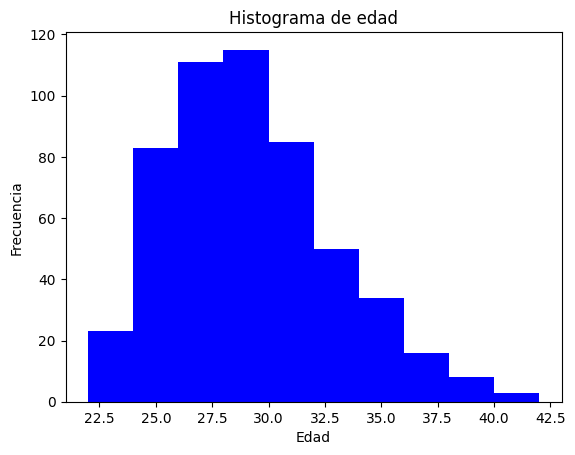

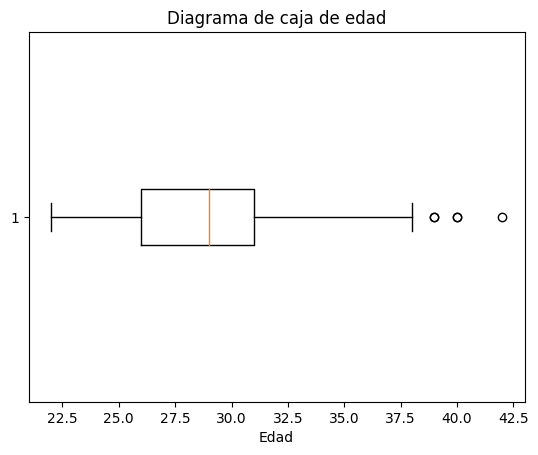

In [11]:
nl = df.loc[df['Lg'] == 'NL']

age = nl['Age']
# Calcular estadísticos descriptivos univariados
mean = age.mean()  # media
median = age.median()  # mediana
mode = age.mode()  # moda
std = age.std()  # desviación estándar
rank = age.max() - age.min()  # rango
quantile = age.quantile([0.25, 0.5, 0.75])  # cuartiles
iqr = quantile[0.75] - quantile[0.25]  # rango intercuartílico


# Mostrar resultados
print('Estadísticos descriptivos univariados')
print('Media:', mean)
print('Mediana:', median)
print('Moda:', mode)
print('Desviación estándar:', std)
print('Rango:', rank)
print('Cuartiles:', quantile)
print('Rango intercuartílico:', iqr)
# Crear histograma
plt.hist(age, bins=10, color='blue')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de edad')

# Crear diagrama de caja
plt.figure()
plt.boxplot(age, vert=False)
plt.xlabel('Edad')
plt.title('Diagrama de caja de edad')

# Mostrar gráficos
plt.show()


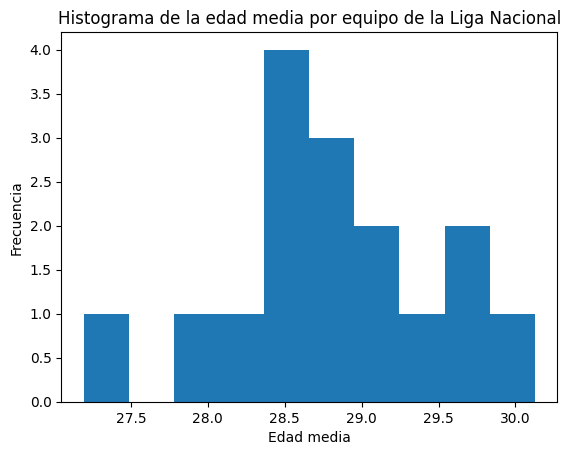

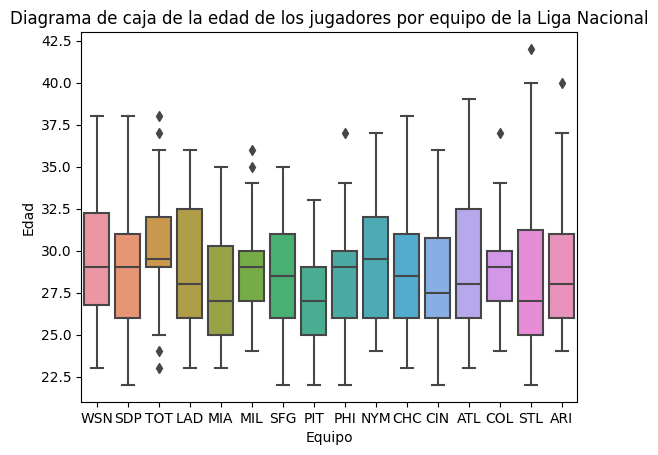

In [18]:
# Agrupar los datos por equipo y calcular la media de la edad de los jugadores
nl_age = nl.groupby('Tm')['Age'].mean()

# Hacer un histograma de la edad media por equipo
plt.hist(nl_age)
plt.xlabel('Edad media')
plt.ylabel('Frecuencia')
plt.title('Histograma de la edad media por equipo de la Liga Nacional')
plt.show()

# Hacer un diagrama de caja de la edad de los jugadores por equipo
sns.boxplot(x='Tm', y='Age', data=nl)
plt.xlabel('Equipo')
plt.ylabel('Edad')
plt.title('Diagrama de caja de la edad de los jugadores por equipo de la Liga Nacional')
plt.show()


### Inciso a

In [4]:
def mean_age(f, age, nl):
    # Hacer ANOVA de un factor si hay más de dos equipos
    if len(f.unique()) > 2:
        # Crear el modelo lineal
        model = ols('age ~ f', data=nl).fit()

        # Crear la tabla ANOVA
        table = sm.stats.anova_lm(model, typ=2)

        # Obtener el valor p del test F
        p = table['PR(>F)'][0]

        # Mostrar el resultado
        print('ANOVA de un factor')
       
        print('El valor p es', p)

        # Si el valor p es menor que 0.05, rechazar la hipótesis nula de que las medias son iguales
        if p < 0.05:
            print('Hay diferencias significativas entre las medias de los equipos')
        else:
            print('No hay diferencias significativas entre las medias de los equipos')

    # Hacer test t si hay solo dos equipos
    else:
        # Obtener el valor t y el valor p del test t
        t, p = stats.ttest_ind(
            age[f == f.unique()[0]], age[f == f.unique()[1]])

        # Mostrar el resultado
        print('Test t para muestras independientes')
        print('El valor t es', t)
        print('El valor p es', p)

        # Si el valor p es menor que 0.05, rechazar la hipótesis nula de que las medias son iguales
        if p < 0.05:
            print('Hay diferencias significativas entre las medias de los equipos')
        else:
            print('No hay diferencias significativas entre las medias de los equipos')


# Seleccionar factor
f = nl['Tm']

mean_age(f, age, nl)


ANOVA de un factor
El valor p es 0.1740010349431162
No hay diferencias significativas entre las medias de los equipos


### Inciso b

In [5]:
new_nl=nl[nl['Tm'].isin(['PIT', 'SDP', 'WSN','ATL'])]
f = new_nl['Tm']
new_age=new_nl['Age']
mean_age(f,new_age,new_nl)


ANOVA de un factor
El valor p es 0.05367316547657668
No hay diferencias significativas entre las medias de los equipos


### Inciso c

/tmp/ipykernel_838/218387180.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_nl = nl.groupby('Tm').mean()


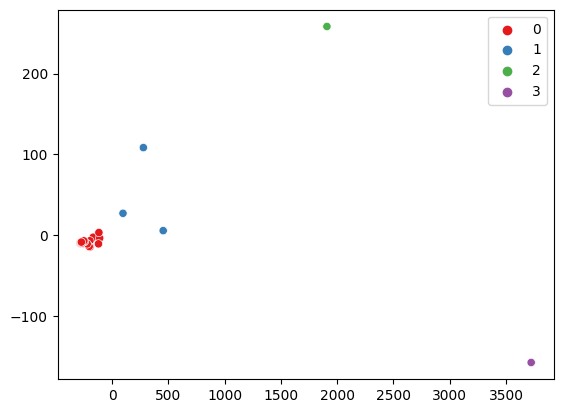

In [6]:
# Agrupar por equipo y calcular medias
new_nl = nl.groupby('Tm').mean()

# Transponer el dataframe
new_nl = new_nl.transpose()

# Convertir a array de numpy
X = new_nl.to_numpy()

# Reducir la dimensión a 2 componentes usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear el árbol jerárquico usando AgglomerativeClustering con 4 clústeres
ac = AgglomerativeClustering(n_clusters=4)
C = ac.fit_predict(X_pca)

# Asignar clústeres a equipos
clusters = dict(zip(new_nl.columns, C))

# Visualizar los clústeres usando un gráfico de dispersión con seaborn
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=C, palette='Set1')
plt.show()
